# Non-signal data exercise

In this exercise you take on the role of a senior data analyst correcting mistakes made by a junior analyst. Your consulting company has received the MysteryData data set, and your goal is to build a classifier out of it, and evaluate how well the classifer works. You assigned the job to junior trainee Tux the Linux Penguin (who works for food).

Tux is very excited to work on the data and has produced very promising results. What Tux does not yet know is that MysteryData is actually just random non-signal data where the features x and the class label y are independent of each other - it is not possible to learn anything meaningful from this data. Tux has never taken any of the UTU data analytics courses and has not noticed this. You should help Tux to correct the analyses, so you do not end up reporting incorrect results to your customers.

You will write your answers inside this notebook. If all your answers are correct, your explanations thorough, and you solve the bonus questions, you will get a bonus point. Use written text, code, printouts or visualizations in you answers as needed. Return both this notebook filled (rename it lastname_firstname_studentid.ipynb), as well as a pdf export of the same notebook (same naming, but .pdf instead).

The analysed problem is a binary classification task. We will follow the convention of using +1 to represent the positive class, and -1 the negative. In all but one task we will use area under ROC curve (AUC) to evaluate how well the classifier predicts. For binary classification tasks AUC and c-index are equivalent, 0.5 means random performance and 1.0 perfect predictions. The "true" AUC you would expect to see on a large enough sample of independent test data for any classifier trained on non-signal data is 0.5.

Note that amount of samples, features, and class distribution for MysteryData can differ in different parts of the exercise (these are always written in comments above the code generating the data). Also, in one case there will be a data set on which it is possible to learn better than random classifier.

Some notes on the codes:
- we use predict_proba() instead of predict() when using AUC, because the predicted class probabilities are needed for computing AUC properly (predict() returns only +1/-1 values)
- random seeds are fixed to guarantee that re-running the codes gives same results

In [2]:
%matplotlib inline
import numpy as np

#The data, trust me, you can't learn anything useful from this
def load_mystery_data(samples, features, positives, random_seed):
    #samples: sample size
    #features: number of features
    #positives: number of positive examples, positives <= samples
    #random_seed: initializes the random generator
    assert positives <= samples
    rand_state = np.random.RandomState(random_seed)
    #values in X are from normal distribution, with zero mean, unit variance, zero covariance
    X = rand_state.randn(samples, features)
    #y is a randomly shuffled vector of +1 and -1 values
    y = np.hstack((np.ones(positives), -1.*np.ones(samples-positives)))
    y = rand_state.permutation(y)
    return X, y

In [3]:
import matplotlib.pyplot as plt

def visualize_chart(X, ref, num_bins = 20):
    hist, bins = np.histogram(permutation_AUCs, bins=num_bins)
    n, bins, patches = plt.hist(X, num_bins, facecolor='blue', alpha=0.5)
    plt.plot([ref, ref],[0, max(hist)], color='red')
    plt.show()

# Part 1: some elementary mistakes

## Lesson 1.1: never trust your ----- set performance

The first analysis done by Tux contains an obvious elementary mistake.

In [4]:
#100 samples, 100 features, 50 belong to positive class
X, y = load_mystery_data(100, 100, 50, 2)

#I am going to try knn on my data!!!
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score


learner = KNeighborsClassifier(n_neighbors=2)
learner.fit(X, y)
#get the estimated probability of belonging to class 1
p = learner.predict_proba(X)[:,1]
auc = roc_auc_score(y, p)
print("I got area under ROC curve %f" % auc)
print('Tux: "I got very high AUC, problem solved!!"')

I got area under ROC curve 0.885600
Tux: "I got very high AUC, problem solved!!"


## Question 1.1
Why can't you trust the AUC result of Tux?

### answer:

It is not a good practice to use the same training data as test data. 

It is like doing an exam that you already know the answers. The teacher would have the impression that students have learnt a lot, but in reality, they did not learn anything.

If the test data is the same as the training data, a high validation result is obtained but this value does not reflect the prediction performance of the model because it is biased.

## Lesson 1.2: trivial baselines

The second analysis done by Tux is done a bit better, but analysis of results contains another elementary mistake.

In [5]:
#1000 samples, 100 features, 100 belong to positive class
X, y = load_mystery_data(1000, 100, 100, 1)

#I am going to try knn on my data!!!
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
#Instead of AUC I will use classification accuracy!
from sklearn.metrics import accuracy_score

#Now I use a separate test set!
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, stratify=y, random_state=1)
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
p_test = knn.predict(X_test)
accuracy = accuracy_score(y_test, p_test)
print("Classification accuracy: %f" %accuracy)
print('Tux: "I got 90% classification accuracy, problem solved!!""')

Classification accuracy: 0.900000
Tux: "I got 90% classification accuracy, problem solved!!""


## Question 1.2
1. Does the high classification accuracy really mean that this is a good predictor?
2. Look at the test set predictions in p_test, what has this classifier actually learned?
3. What would the results look like if you used AUC instead of classification accuracy?

### answer:

1. The problem is how to interpret high classification accuracy with imbalanced classes. If 90% of examples belong to one class, predicting that class will give you trivially 90% accuracy.
2. The test predictions in p_test are always negative (-1). The classifier only learned to classify everything as negative
3. AUC actually close but not quite equal to 0.5 - remember, AUC is properly computed from the real-valued predictions given by predict_proba(), not the discrete predictions returned by predict()

# Part 2: introduction to permutation tests

Next, we are using permutation tests to estimate, how likely we are to see AUC values as high as observed, if y is independent of x (non-signal data).

The test is implemented as follows:
- let AUC_original be the AUC obtained in the original analysis
- For 1000 (or preferably more if you have enough CPU time to use) repetitions, shuffle the labels in y, then run the analysis again and compute the AUC value. Store all 1000 AUC values in a list.
- Visualization: visualize the permutation distribution by plotting a histogram of the 1000 AUC values. Does AUC_original look like an outlier, or do you often get as good or better results with permuted class labels?
- p-value: relative fraction of runs, where obtained AUC $\geq$ AUC_original
- example: AUC with original class labeling is 0.6. In 70 runs out of 1000, we obtain as high as or larger AUC. p-value is then $\frac{70}{1000} = 0.07$ 
- result is considered statistically significant, if $p<\alpha$, where $\alpha$ a pre-specified significance level (often $\alpha=0.05$ or $\alpha=0.01$). Statistical significance does not mean that the results are good, only that the classifier has likely learned something from the data. In the following experiments, use $\alpha=0.05$.

## Lesson 2.1: sample size

Tux is now analyzing a small data set with 5-fold cross-validation. 

In [8]:
#20 samples, 10 features, 10 belong to positive class
X, y = load_mystery_data(20, 10, 10, 10)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=5)
cv_aucs = []
for train, test in cv.split(X, y):
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    p_test = knn.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, p_test)
    cv_aucs.append(auc)
auc = np.mean(cv_aucs)
print("AUC: %f" %auc)
print('Tux: "I did proper cross-validation and got better than random results. My classifier learned something!!"')

AUC: 0.700000
Tux: "I did proper cross-validation and got better than random results. My classifier learned something!!"


## Question 2.1
Implement a permutation test for the above analysis, are these results statistically significant with $\alpha=0.05$? Provide both visualization of the permutation distribution, as well as the p-value.

P_value:  0.106


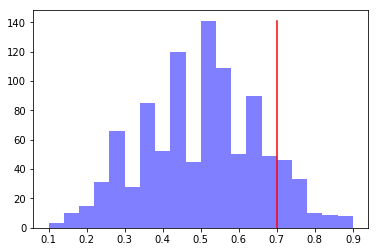

In [53]:
ref = 0.7

import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
  
#20 samples, 10 features, 10 belong to positive class
X, y = load_mystery_data(20, 10, 10, 10)

permutation_AUCs = []
for p in range(1000):
    # permutate class labels
    np.random.shuffle(y)
    
    ###

   
    cv = StratifiedKFold(n_splits=5)
    cv_aucs = []
    for train, test in cv.split(X, y):
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train, y_train)
        p_test = knn.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, p_test)
        cv_aucs.append(auc)
    auc = np.mean(cv_aucs)
    permutation_AUCs.append(auc)

permutation_AUCs = np.array(permutation_AUCs)
better_permutation_AUCs = permutation_AUCs[permutation_AUCs >= ref]
p = better_permutation_AUCs.size / permutation_AUCs.size
print("P_value: ", p)


visualize_chart(permutation_AUCs, ref)

### answer
The value is not statistically significant because the p_value is bigger than $\alpha=0.05$ and we can conclude that the model has not learned anything from the data.



## Lesson 2.2: sample size again

Let's give poor Tux a better data set that actually has clear difference between the classes and see how things work out. (on this data it is possible to obtain true AUC larger than 0.5)

In [54]:
def load_new_mystery_data(samples, features, positives, random_seed):
    #samples: sample size
    #features: number of positive examples, positives <= samples
    #random_seed: initializes the random generator
    assert positives <= samples
    rand_state = np.random.RandomState(random_seed)
    #values in X are from normal distribution, with zero mean, unit variance, zero covariance
    X_pos = rand_state.randn(positives, features)
    X_neg = rand_state.randn(samples-positives, features)+0.65
    X = np.vstack((X_pos, X_neg))
    #y is a randomly shuffled vector of +1 and -1 values
    y = np.hstack((np.ones(positives), -1.*np.ones(samples-positives)))
    I = rand_state.permutation(samples)
    X = X[I]
    y = y[I]
    return X, y

In [55]:
#20 samples, 10 features, 10 belong to positive class
X, y = load_new_mystery_data(20, 10, 10, 10)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

cv = StratifiedKFold(n_splits=5)
cv_aucs = []
for train, test in cv.split(X, y):
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    p_test = knn.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, p_test)
    cv_aucs.append(auc)
cv_auc = np.mean(cv_aucs)
print("AUC: %f" %cv_auc)
print('Tux: "Not sure if I can trust the results anymore, my data set is really small! Please help me compute the p-value!!"')

AUC: 0.875000
Tux: "Not sure if I can trust the results anymore, my data set is really small! Please help me compute the p-value!!"


P_value:  0.003


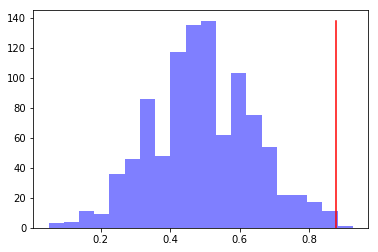

In [47]:
ref = 0.875000

import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
  
#20 samples, 10 features, 10 belong to positive class
X, y = load_new_mystery_data(20, 10, 10, 10)

permutation_AUCs = []
for p in range(1000):
    # permutate class labels
    np.random.shuffle(y)
    
    # CV
    cv = StratifiedKFold(n_splits=5)
    cv_aucs = []
    for train, test in cv.split(X, y):
        X_train = X[train]
        y_train = y[train]
        X_test = X[test]
        y_test = y[test]
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train, y_train)
        p_test = knn.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, p_test)
        cv_aucs.append(auc)
    auc = np.mean(cv_aucs)
    # End CV
    permutation_AUCs.append(auc)
    
permutation_AUCs = np.array(permutation_AUCs)
better_permutation_AUCs = permutation_AUCs[permutation_AUCs >= ref]
p = better_permutation_AUCs.size / permutation_AUCs.size
print("P_value: ", p)

visualize_chart(permutation_AUCs, ref)

## Question 2.2
Implement a permutation test for the above analysis, are these results statistically significant with $\alpha=0.05$? Provide both visualization of the permutation distribution, as well as the p-value.



### answer
The value is statistically significant because the p_value is lower than $\alpha=0.05$ and we can conclude that the model has learned from the data.



# Part 3: mis-using feature selection

Here is a very simple correlation based feature selection method

In [56]:
from scipy.stats import kendalltau

def select(X, Y, scount):
    #select scount features from X with highest correlation with Y
    correlations = []
    for i in range(X.shape[1]):
        corr = kendalltau(X[:,i], Y)[0]
        correlations.append(np.abs(corr))
    correlations = np.array(correlations)
    I = np.argsort(correlations)
    I = I[::-1]
    return X[:,I[:scount]]

In [20]:
#50 samples, 1000 features, 25 belong to positive class
X, y = load_mystery_data(50, 1000, 25, 1)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score


cv = StratifiedKFold(n_splits=5)
cv_aucs = []
for train, test in cv.split(X, y):
    X_train = X[train]
    y_train = y[train]
    X_test = X[test]
    y_test = y[test]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    p_test = knn.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, p_test)
    cv_aucs.append(auc)
cv_auc = np.mean(cv_aucs)
print('Tux: "My CV-AUC before feature selection is %f"' %cv_auc)


#I'm going to improve my AUC with feature selection!!!
X_fs = select(X, y, 5)
cv_aucs = []
for train, test in cv.split(X_fs, y):
    X_train = X_fs[train]
    y_train = y[train]
    X_test = X_fs[test]
    y_test = y[test]
    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_train, y_train)
    p_test = knn.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, p_test)
    cv_aucs.append(auc)
cv_auc = np.mean(cv_aucs)
print('Tux: "My CV-AUC after feature selection is %f, it really works!!"' %cv_auc)

Tux: "My CV-AUC before feature selection is 0.496000"
Tux: "My CV-AUC after feature selection is 0.808000, it really works!!"


## Question 3.1

Use permutation test to show Tux that the feature selection based classification approach is actually not learning anything from the data ($\alpha=0.05$, provide both visualization of the permutation distribution, as well as the p-value). Running the test may take a while. Analyse what is going on here, why did the results look so good?

P_value:  0.672


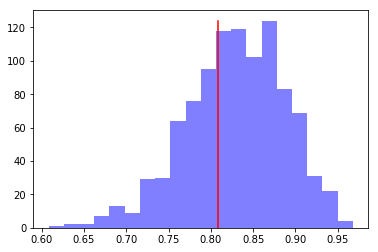

In [57]:
ref = 0.808000

import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
  
#50 samples, 1000 features, 25 belong to positive class
X, y = load_mystery_data(50, 1000, 25, 1)

permutation_AUCs = []
for i in range(1000):
    # permutate class labels
    np.random.shuffle(y)
    
    # bad feature selection
    
    #I'm going to improve my AUC with feature selection!!!
    X_fs = select(X, y, 5)
    cv_aucs = []
    for train, test in cv.split(X_fs, y):
        X_train = X_fs[train]
        y_train = y[train]
        X_test = X_fs[test]
        y_test = y[test]
        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_train, y_train)
        p_test = knn.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, p_test)
        cv_aucs.append(auc)
    cv_auc = np.mean(cv_aucs)
    
    # End
    permutation_AUCs.append(cv_auc)
    
permutation_AUCs = np.array(permutation_AUCs)
better_permutation_AUCs = permutation_AUCs[permutation_AUCs >= ref]
p = better_permutation_AUCs.size / permutation_AUCs.size
print("P_value: ", p)


visualize_chart(permutation_AUCs, ref)

### answer
The value is not statistically significant because the p_value is bigger than $\alpha=0.05$ and we can conclude that the model has not learned anything from the data.



## Question 3.2 (bonus exercise)

Correct the bias in above example by combining feature selection properly with cross-validation, run the experiment again. Do also a permutation test for this experiment with as many permutations as you can afford in a reasonable amount of time.

Q 3.2. Bonus question is not solved correctly - in the correct solution you would select the features only on the training folds, not all folds. If done correctly, the AUC values would fall close to 0.5.

In [75]:
#50 samples, 1000 features, 25 belong to positive class
X, y = load_mystery_data(50, 1000, 25, 1)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

def select_indexes(X, Y, scount):
    #select scount features from X with highest correlation with Y
    correlations = []
    for i in range(X.shape[1]):
        corr = kendalltau(X[:,i], Y)[0]
        correlations.append(np.abs(corr))
    correlations = np.array(correlations)
    I = np.argsort(correlations)
    I = I[::-1]
    return I[:scount]


#I'm going to improve my AUC with feature selection!!!
cv_aucs = []
for train, test in cv.split(X, y):
    
    X_train = X[train]

    #I'm going to improve my AUC with feature selection!!!
    I = select_indexes(X_train, y, 5) # feature indexes
    
    # filtered by selected features
    X_fs_train = X_train[:, I]
    
    y_train = y[train]

    # filtered by test and selected features
    X_test = X[test]
    X_fs_test = X_test[:, I]
    
    y_test = y[test]

    knn = KNeighborsClassifier(n_neighbors=3)
    knn.fit(X_fs_train, y_train)
    p_test = knn.predict_proba(X_fs_test)[:,1]
    auc = roc_auc_score(y_test, p_test)
    cv_aucs.append(auc)

cv_auc = np.mean(cv_aucs)
print('Tux: "My CV-AUC after feature selection is %f, it really works!!"' %cv_auc)

Tux: "My CV-AUC after feature selection is 0.808000, it really works!!"


P_value:  0.6646666666666666


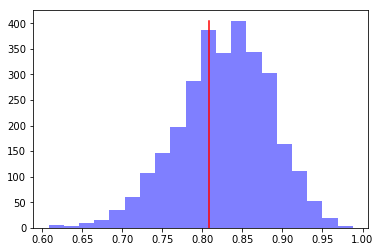

In [76]:
from scipy.stats import kendalltau

ref = 0.808000

import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
  
#50 samples, 1000 features, 25 belong to positive class
X, y = load_mystery_data(50, 1000, 25, 1)

permutation_AUCs = []
for p in range(3000):
    # permutate class labels
    np.random.shuffle(y)
    
    # good feature selection
    
    #I'm going to improve my AUC with feature selection!!!
    cv_aucs = []
    for train, test in cv.split(X, y):

        X_train = X[train]

        #I'm going to improve my AUC with feature selection!!!
        I = select_indexes(X_train, y, 5) # feature indexes

        # filtered by selected features
        X_fs_train = X_train[:, I]

        y_train = y[train]

        # filtered by test and selected features
        X_test = X[test]
        X_fs_test = X_test[:, I]

        y_test = y[test]

        knn = KNeighborsClassifier(n_neighbors=3)
        knn.fit(X_fs_train, y_train)
        p_test = knn.predict_proba(X_fs_test)[:,1]
        auc = roc_auc_score(y_test, p_test)
        cv_aucs.append(auc)
    # End
    
    cv_auc = np.mean(cv_aucs)

    permutation_AUCs.append(cv_auc)
    
permutation_AUCs = np.array(permutation_AUCs)
better_permutation_AUCs = permutation_AUCs[permutation_AUCs >= ref]
p = better_permutation_AUCs.size / permutation_AUCs.size
print("P_value: ", p)


visualize_chart(permutation_AUCs, ref)

### answer

The value is not statistically significant because the p_value is bigger than $\alpha=0.05$ and we can conclude that the model has not learned anything from the data.
